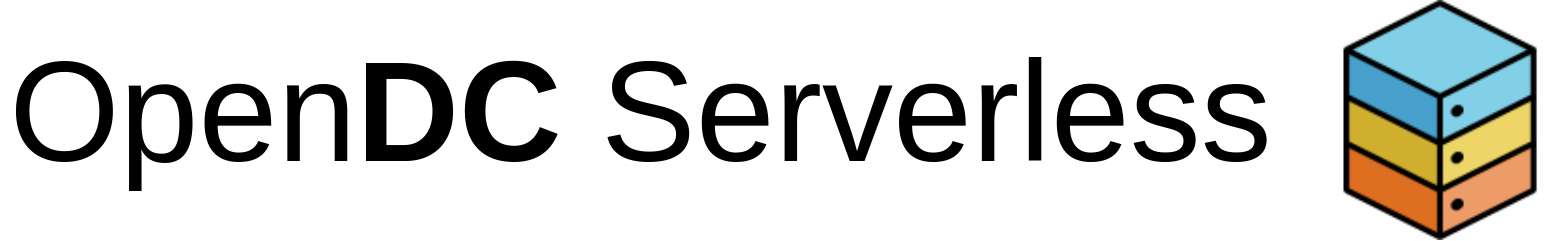
# FaaS Trace Synthesizer
This Notebook presents a general approach for generating synthetic traces for the OpenDC Serverless simulator (unused in the paper)

This work accompanies the OpenDC Serverless bachelors thesis paper by Soufiane Jounaid within @Large Research

Vrije Universiteit Amsterdam 2020.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from scipy import stats 
from scipy.interpolate import interp1d
from enum import Enum, auto
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

## Pattern enumerations

In [ ]:
class Invocation_pattern(Enum):
    UNIFORM = auto()
    HOTNCOLD = auto()

class Executiontime_pattern(Enum):
    UNIFORM = auto()
    HOTNCOLD = auto()

class Cpuusage_pattern(Enum):
    UNIFORM = auto()
    HOTNCOLD = auto()
    
class Memoryusage_pattern(Enum):
    UNIFORM = auto()
    HOTNCOLD = auto()
    

## Statistical utility

In [ ]:
def uniform_sample(high, low, size):
    return np.random.randint(low,high,size)

def empirical_sample(size, ecdf):
    inv_cdf = interp1d(ecdf.y, ecdf.x, bounds_error = False, assume_sorted=True)
    r = np.random.uniform(0, 1, size)
    return inv_cdf(r)
    
def bimodal_ecdf(loc1,loc2,scale1,scale2,size1,size2):
    sample1 = np.random.normal(loc=loc1, scale=scale1, size=size1)
    sample2 = np.random.normal(loc=loc2, scale=scale2, size=size2)
    bimodal_sample = np.hstack((sample1, sample2))
    return ECDF(bimodal_sample)


## Pipeline


### Setting timestamps

In [ ]:
def set_timestamps(dataframe, duration, interval):
    nr_entries = round(duration / interval)
    time_increment = 0
    for i in range(nr_entries):
        time_increment += interval
        new_row = {'Timestamp [ms]':time_increment,
                   'Invocations':0,
                   'Exec_time':0,
                   'Provisioned_cpu':0,'Provisioned_memory':0,
                   'Avg_cpu':0,
                   'Avg_mem':0}
        dataframe = dataframe.append(new_row, ignore_index=True)
    return dataframe



### Generating invocations


In [ ]:
def set_invocations(dataframe, pattern):
    high = int(input("please input the highest number concurrent invocations:"))
    low = int(input("please input the lowest number concurrent invocations:"))
    size = len(dataframe.index)
    
    positive = lambda t: sqrt(t ** 2)
    limit = lambda t: high if t > high else t
    
    if (pattern == Invocation_pattern.UNIFORM):
        sample_invocs = uniform_sample(high, low, size)
        return dataframe.assign(Invocations=sample_invocs)
    
    elif (pattern == Invocation_pattern.HOTNCOLD):
        sd = int(input("please input the standard deviation:"))
        high_size = int(float(input("please input the proportion of high concurrency")) * (size * 1000))
        low_size = size*1000 - high_size
        ecdf = bimodal_ecdf(low,high,sd,sd,low_size,high_size)
        sample_invocs = empirical_sample(size, ecdf)
        return dataframe.assign(Invocations=np.array([positive(limit(invoc)) for invoc in sample_invocs]).astype(np.int))

### Generating Execution time

In [ ]:
def set_exectimes(dataframe, pattern):
    high = int(input("please input the highest exec time:"))
    low = int(input("please input the lowest exec time:"))
    size = len(dataframe.index)
    
    positive = lambda t: sqrt(t ** 2)
    limit = lambda t: high if t > high else t
    
    if (pattern == Executiontime_pattern.UNIFORM):
        sample_times = uniform_sample(high, low, size)
        return dataframe.assign(Exec_time=sample_times)
    
    elif (pattern == Executiontime_pattern.HOTNCOLD):
        sd = int(input("please input the standard deviation:"))
        high_size = int(float(input("please input the proportion of high exec times:")) * (size * 1000))
        low_size = size*1000 - high_size
        ecdf = bimodal_ecdf(low,high,sd,sd,low_size,high_size)
        sample_times = empirical_sample(size, ecdf)
        return dataframe.assign(Exec_time=np.array([positive(limit(time)) for time in sample_times]).astype(np.int))

### Setting provisioning values

In [ ]:
def set_provisioning(dataframe, prov_cpu, prov_mem):
    dataframe = dataframe.assign(Provisioned_cpu=prov_cpu)
    return dataframe.assign(Provisioned_memory=prov_mem)

### Generating Allocated cpu

In [ ]:
def set_cpuusage(dataframe, pattern):
    high = float(input("please input the highest cpu usage in Mhz:"))
    low = float(input("please input the lowest cpu usage in Mhz:"))
    size = len(dataframe.index)
    
    positive = lambda t: sqrt(t ** 2)
    limit = lambda t: high if t > high else t
    
    if (pattern == Cpuusage_pattern.UNIFORM):
        sample_cpu = uniform_sample(high, low, size)
        return dataframe.assign(Avg_cpu=sample_cpu)
    
    elif (pattern == Cpuusage_pattern.HOTNCOLD):
        sd = float(input("please input the standard deviation:"))
        high_size = int(float(input("please input the proportion of high cpu usage:")) * (size * 1000))
        low_size = size*1000 - high_size
        ecdf = bimodal_ecdf(low,high,sd,sd,low_size,high_size)
        sample_cpu = empirical_sample(size, ecdf)
        return dataframe.assign(Avg_cpu=np.array([positive(limit(cpu)) for cpu in sample_cpu]).astype(np.float64))

### Generating Allocated memory

In [ ]:
def set_memusage(dataframe, pattern):
    high = float(input("please input the highest memory usage in mb:"))
    low = float(input("please input the lowest memory usage in mb:"))
    size = len(dataframe.index)
    
    positive = lambda t: sqrt(t ** 2)
    limit = lambda t: high if t > high else t
    
    if (pattern == Memoryusage_pattern.UNIFORM):
        sample_mem = uniform_sample(high, low, size)
        return dataframe.assign(Avg_mem=sample_mem)
    
    elif (pattern == Memoryusage_pattern.HOTNCOLD):
        sd = float(input("please input the standard deviation:"))
        high_size = int(float(input("please input the proportion of high memory usage:")) * (size * 1000))
        low_size = size*1000 - high_size
        ecdf = bimodal_ecdf(low,high,sd,sd,low_size,high_size)
        sample_mem = empirical_sample(size, ecdf)
        return dataframe.assign(Avg_mem=np.array([positive(limit(mem)) for mem in sample_mem]).astype(np.float64))

## Initial input handling

In [ ]:

try:
    seed = int(input("Seed:"))
    nr_functions = int(input("Number of functions:"))
    trace_duration = int(input("Duration of the trace in ms"))
    time_interval = int(input("Time interval between trace entries in ms:"))
    np.random.seed(seed)
    invoc_patterns = []
    exectime_patterns = [] 
    cpuusage_patterns = [] 
    memusage_patterns = []
    provisioned_cpu = []
    provisioned_mem = []
    for i in range(nr_functions):
        provisioned_cpu.append(int(input("Provisioned cpu for function {0} :".format(i+1))))
        provisioned_mem.append(int(input("Provisioned memory for function {0} :".format(i+1))))
        invoc_patterns.append(Invocation_pattern(int(input("choose invocation pattern for function {0} :".format(i+1)))))
        exectime_patterns.append(Executiontime_pattern(int(input("choose exec time pattern for function {0} :".format(i+1)))))
        cpuusage_patterns.append(Cpuusage_pattern(int(input("choose cpu usage pattern for function {0} :".format(i+1)))))
        memusage_patterns.append(Memoryusage_pattern(int(input("choose mem usage pattern for function {0} :".format(i+1)))))
except ValueError:
    print("Invalid input type")
    

    

## Dataframe Initialization

In [ ]:
dataframe_list = []
trace_template = {'Timestamp [ms]':[],
                  'Invocations':[],
                  'Exec_time':[],
                  'Provisioned_cpu':[],'Provisioned_memory':[],
                  'Avg_cpu':[],
                  'Avg_mem':[]}
trace_dtypes = {'Timestamp [ms]':int,
                  'Invocations':int,
                  'Exec_time':int,
                  'Provisioned_cpu':int,'Provisioned_memory':int,
                  'Avg_cpu':float,
                  'Avg_mem':float}

for i in range(nr_functions):
    dataframe_list.append(pd.DataFrame(data=trace_template).astype(trace_dtypes))


## Processing

In [ ]:
for index, dataframe in enumerate(dataframe_list, start=0):
    print("\nfunction {0}\n".format(index+1))
    dataframe = set_timestamps(dataframe, trace_duration, time_interval)
    dataframe = set_provisioning(dataframe, provisioned_cpu[index], provisioned_mem[index])
    dataframe = set_invocations(dataframe, invoc_patterns[index])
    dataframe = set_exectimes(dataframe, exectime_patterns[index])
    dataframe = set_cpuusage(dataframe, cpuusage_patterns[index])
    dataframe = set_memusage(dataframe, memusage_patterns[index])
    dataframe = dataframe.rename(columns={'Exec_time':' Avg Exec time per Invocation',
                                          'Provisioned_cpu':'Provisioned CPU [Mhz]',
                                          'Provisioned_memory':'Provisioned Memory [mb]',
                                          'Avg_cpu':' Avg cpu usage per Invocation [Mhz]',
                                          'Avg_mem':' Avg mem usage per Invocation [mb]'})
    dataframe.to_csv(r'{0}.csv'.format(index+1),index=False)